# FitzHugh-Nagumo: Nonlinear Dynamical System Analysis

Charles Xu @ Caltech

## System setup

The [FitzHugh-Nagumo Model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model) is a two-dimensional simplification of the Hodgkin-Huxley Model of spike generation in squid giant axons. It is given by two differential equations:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = \epsilon(v+a-bw)
\end{cases},$$
where:
- $v$ is the membrane potential;
- $w$ is the recovery variable;
- $I$ is the stimulus current;
- $a$, $b$, and $\epsilon$ are parameters that dictate the system's behavior.

To simplify the analysis, I will specify the constant values of the parameters $a$, $b$, and $\epsilon$ empirically determined from squid giant axons. The empirical system is given by:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = 0.08(v+0.7-0.8w)
\end{cases}.$$

In [1]:
## Set up the system of differential equations for the FitzHugh-Nagumo model
import sympy as sp

# Define the variables
v, w = sp.symbols('v w')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I_stim = 0

# Define the system of differential equations
dv_dt = v - (v**3)/3 - w + I_stim
dw_dt = epsilon * (v + a - b*w)
f = sp.Matrix([dv_dt, dw_dt])

# Print the equations
print("dv/dt =", dv_dt)
print("dw/dt =", dw_dt)

dv/dt = -v**3/3 + v - w
dw/dt = 0.08*v - 0.064*w + 0.056


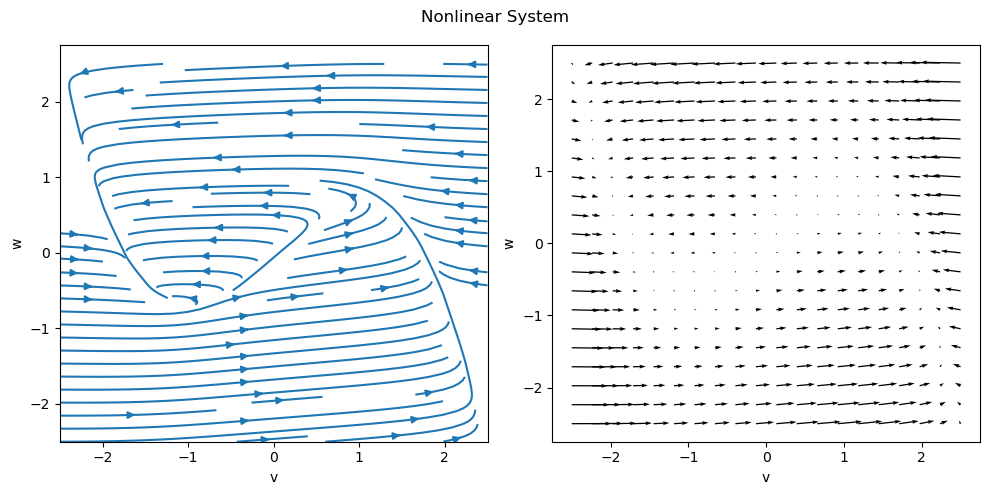

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Phase portrait for the nonlinear system
# Define the nonlinear system
def nl_system(v, w):
    return v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)

# Define the grid
vs = np.linspace(-2.5, 2.5, 20)
ws = np.linspace(-2.5, 2.5, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = nl_system(Vs, Ws)

# Plot the phase portrait
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].streamplot(Vs, Ws, v_direction, w_direction)
axs[0].set_xlabel('v')
axs[0].set_ylabel('w')

axs[1].quiver(Vs, Ws, v_direction, w_direction)
axs[1].set_xlabel('v')
axs[1].set_ylabel('w')

plt.suptitle('Nonlinear System')
plt.tight_layout()
plt.show()

## Lipschitz continuity of the system

Define a state vector $x\in\mathbb{R}^2$:
$$x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} v \\ w \end{bmatrix}.$$
The dynamics can be written in $\dot{x} = f(x)$:
$$\dot{x} = f(x) = \begin{bmatrix} v-\frac{v^3}{3}-w+I \\ 0.08(v+0.7-0.8w) \end{bmatrix},$$
where $f(x)$ is continuously differentiable with respect to both $v$ and $w$.

Taking the Jacobian gives:
$$Df(x) = \begin{bmatrix} 1-v^2 & -1 \\ 0.08 & -0.064 \end{bmatrix}.$$
The partial derivative $\frac{\delta f}{\delta v} = 1-v^2$ grows unboundedly with $v$, so we can conclude that the system $\dot{x}=f(x)$ is not globally Lipschitz continuous. However, because $f(x)$ is continuously differentiable, a local Lipschitz constant $L_0$ can be found by:
$$L_0 = \max_{x\in B_\epsilon(x_0)} \|Df(x)\|,$$
indicating that at some point $x_0\in\mathbb{R}^2$, there exists such $L_0$ and some arbitrarily small $\epsilon\in\mathbb{R}_{>0}$ such that $x\in B_\epsilon(x_0)$ implies $\|Df(x)\|\le L_0$.

In [3]:
## Compute the local Lipschitz constant
from scipy.optimize import minimize

# Compute the Jacobian
Df = f.jacobian([v, w])

# Store the eigenvalues as functions of v and w
eig_Df = Df.eigenvals()
eig_funcs = [sp.lambdify([v, w], abs(eig)) for eig in eig_Df.keys()] 

# Define the objective function
def objective(x):
    v, w = x
    return -max([eig_func(v, w) for eig_func in eig_funcs])

# Initial guess for v and w
x0 = [0.0, 0.0]

# Solve the optimization problem
res = minimize(objective, x0, method='SLSQP', bounds=[(-2, 2), (-2, 2)])
L0 = -res.fun
print("L0 =", L0)

L0 = 0.9185818460612902


### Local Lipschitz constant

For a bounded region $v:(-2, 2), w:(-2, 2)$ around $x_0 = [0, 0]$, the local Lipschitz constant is $L_0 = 0.92$

## Solutions to the system

For nonlinear systems, solutions may not be unique or even exist for all time. Therefore, I would like to demonstrate the existence and uniqueness of solutions for this system by the Picard's method of approximation: $$z_{n+1} = P(z_n),\quad z_0 = x_0,$$
where the Picard operator defined on continuous functions $C(I,E)$ is given by: $$\begin{align*}P: C(I,E) &\to C(I,E)\\ \phi(t) &\mapsto P(\phi)(t) = x_0 + \int_{t_0}^t f(\phi(s))ds \end{align*}.$$

The sequence of Picard operators is a Cauchy sequence which converges to a fixed point $\lim_{n\to\infty}z_n = z^*$, which exists and is the unique solution of the initial value problem (IVP): $z^* = x(t)$. This can be proven by showing that $P: C(I,E) \to C(I,E)$ is a contraction mapping using the Contraction Mapping Principle.

### Set initial conditions

In [4]:
## Set the initial conditions
import numpy as np

# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the initial condition
x0 = [0.0, 0.0]

### Solve using Picard Iteration

In [5]:
## Solve using Picard Iteration
from scipy.integrate import cumtrapz

# Define the system of equations
def f(x):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Initialize the solution
xt = np.tile(x0, (n, 1)).T

# Define tolerance
delta = np.inf
tol = 1e0

# Compute the solution
while delta > tol:
    xt_next = np.tile(x0, (n, 1)).T + cumtrapz(f(xt), t, initial=0, axis=1)
    delta = np.linalg.norm(xt_next - xt)
    print("delta =", delta)
    xt = xt_next
xt_picard = xt

delta = 1.6206578869496147
delta = 3.1606011270734604
delta = 3.9918878191853495
delta = 2.187513769825797
delta = 1.2363007631160456
delta = 0.482510819279465


**Theorem**

*Consider a locally Lipschitz continuous function: $f: E\to\mathbb{R}^n$ defined on the open and connected set $E \subseteq \mathbb{R}^n$. For any $x_0\in E$, there exists $a\in\mathbb{R}_{>0}$ for which the IVP: $$\dot{x} = f(x),\quad x(t_0) = x_0$$ has a unique solution, $x(t)$, on the interval $I = (t_0-a, t_0+a)$.*

Therefore, demonstrating that the system is locally Lipschitz implies that for any IVP, we are guaranteed a unique solution on an open interval.

### Solve using ODE solver

In [6]:
## Solve using ODE solver
from scipy.integrate import solve_ivp

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Compute the solution
sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, method='RK45')
xt_ode45 = sol.y

### Compare the solutions

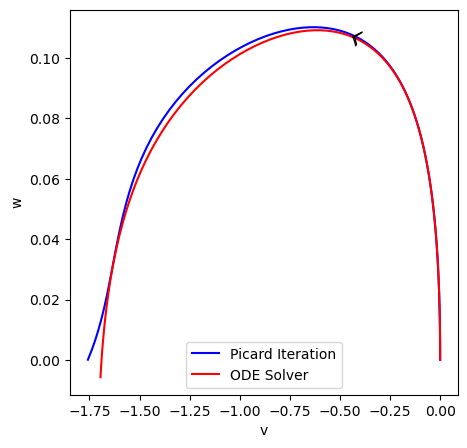

In [7]:
## Compare the solutions of the two methods
import matplotlib.pyplot as plt

# Plot the solutions
plt.figure(figsize=(5, 5))
plt.plot(xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
plt.plot(xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')
middle_index = len(xt_picard[0]) // 2

# Add arrows to indicate direction
plt.annotate('', xy=(xt_picard[0][middle_index], xt_picard[1][middle_index]), xytext=(xt_picard[0][middle_index-1], xt_picard[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor='blue'))
plt.annotate('', xy=(xt_ode45[0][middle_index], xt_ode45[1][middle_index]), xytext=(xt_ode45[0][middle_index-1], xt_ode45[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor='red'))
plt.xlabel('v')
plt.ylabel('w')
plt.legend()
plt.show()

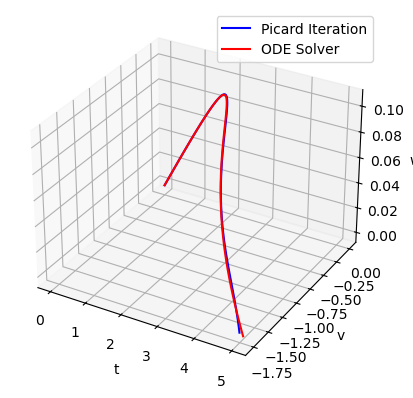

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the solutions
ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

ax.set_xlabel('t')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.legend()

plt.show()

In [9]:
from ipywidgets import interact

def plot_func(angle1=30, angle2=30):
    # Create a new figure
    fig = plt.figure()

    # Create a 3D axis
    ax = fig.add_subplot(111, projection='3d')

    # Plot the solutions
    ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
    ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

    ax.set_xlabel('t')
    ax.set_ylabel('v')
    ax.set_zlabel('w')
    ax.legend()

    # Set the viewing angle
    ax.view_init(angle1, angle2)

    plt.show()

interact(plot_func, angle1=(0,360), angle2=(0,360))

interactive(children=(IntSlider(value=30, description='angle1', max=360), IntSlider(value=30, description='ang…

<function __main__.plot_func(angle1=30, angle2=30)>

## Continuity of solutions
### Continuous dependence on initial conditions

Continuity for initial conditions implies that for small changes in final position: $\|z(t)-x(t)\| < \epsilon, \space\forall\epsilon > 0$, one could find a small enough difference in initial conditions to satisfy the condition: $\exists\delta>0$ s.t. $\|z_0-x_0\| < \delta$.

We can demonstrate the continuous dependence of this system on initial conditions by slightly purturbing the initial conditions and visualizing it on a bounded interval.

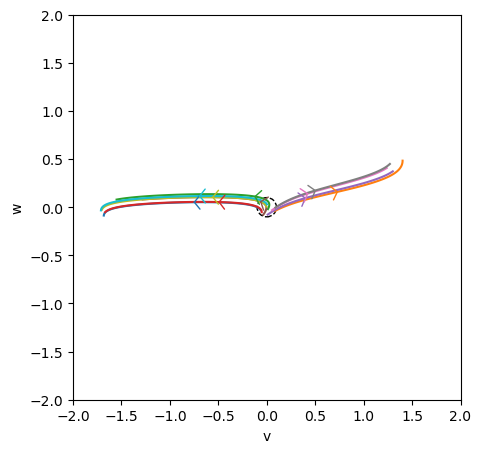

In [10]:
## Solve the system of equations for the purturbed initial conditions
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Generate the purturbed initial conditions
num_conditions = 10
radius = 0.1
angles = 2 * np.pi * np.random.rand(num_conditions)
radii = radius * np.sqrt(np.random.rand(num_conditions))
z0s = np.array([radii * np.cos(angles), radii * np.sin(angles)]).T

# Create a new figure
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over the initial conditions
for z0 in z0s:
    # Compute the solution
    sol = solve_ivp(f, [t0, t_final], z0, t_eval=t, method='RK45')
    zt = sol.y

    # Plot the solution
    line, = ax.plot(zt[0], zt[1])

    # Add arrows to indicate direction
    middle_index = len(zt[0]) // 2
    arrowcolor = np.array(mcolors.to_rgba(line.get_color()))
    ax.annotate('', xy=(zt[0][middle_index], zt[1][middle_index]), xytext=(zt[0][middle_index-1], zt[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor=arrowcolor, edgecolor=arrowcolor))

# Draw the ball
circle = patches.Circle((0, 0), radius, fill=False, linestyle='dashed', edgecolor='black')
ax.add_patch(circle)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

#### Boundary value $\mu$

We can compute a boundary value $\mu$ for the solution difference between the original and perturbed system, $g$, satisfying the following inequality: $$\|x(t)-z(t)\| \le \|x_0-z_0\|e^{L(t-t_0)} + \mu(t-t_0)e^{L(t-t_0)}.$$
Thus, $\mu$ is given by: $$\mu = \frac{\|x(t)-z(t)\| - \|x_0-z_0\|e^{L(t-t_0)}}{(t-t_0)e^{L(t-t_0)}}.$$

In the following demonstration, let's perturb the system by setting initial condition from $x_0$ to $z_0 = [0.1, 0.0]$.

In [11]:
## Compute the bound on the distance between the solutions, mu
# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the initial conditions
x0 = np.array([0.0, 0.0])
z0 = np.array([0.1, 0.0])

# Initialize the solutions
xt = np.tile(x0, (n, 1)).T
zt = np.tile(z0, (n, 1)).T

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Compute the solutions
x0_sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, method='RK45')
xt = x0_sol.y
z0_sol = solve_ivp(f, [t0, t_final], z0, t_eval=t, method='RK45')
zt = z0_sol.y

# Compute mu
mu = (np.linalg.norm(xt - zt) - np.linalg.norm(x0 - z0) * np.exp(L0 * (t_final - t0))) / (t_final - t0) * np.exp(L0 * (t_final - t0))
print("mu =", mu)

mu = 135.36024740583753


In [12]:
## Compute the left- and right-hand sides of the inequality
lhs = np.linalg.norm(xt - zt, axis=0)
rhs = np.linalg.norm(x0 - z0) * np.exp(L0 * (t - t0)) + mu * (t - t0) * np.exp(L0 * (t - t0))

if np.all(lhs <= rhs):
    print("The inequality is satisfied at all times!")
else:
    print("The inequality is NOT satisfied at all times!")

The inequality is satisfied at all times!


Thus, our $\mu$ successfully bounds the solution of the perturbed system $z(t)$.

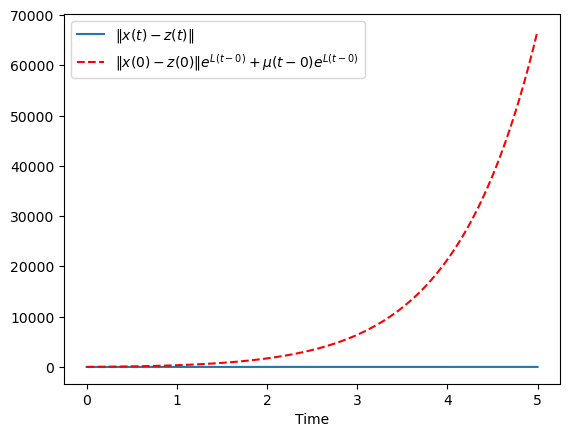

In [13]:
## Plot the time-varying upper bound on the distance between the solutions
fig, ax = plt.subplots()
ax.plot(t, lhs, label='$\|x(t) - z(t)\|$')
ax.plot(t, rhs, 'r--', label='$\|x(0) - z(0)\| e^{L(t - 0)} + \mu (t - 0) e^{L(t - 0)}$')
ax.set_xlabel('Time')
ax.legend()
plt.show()

### Continuous dependence on parameters

Continuity for parameters can be similarly demonstrated by purturbing the system's parameters slightly and examining the resulting solutions to IVPs with respect to the same initial conditions. For the FitzHugh-Nagumo system, we can perturb one of the parameters, $I$, to simulate an external current injection into the neuron. Let's set $I = 10$.

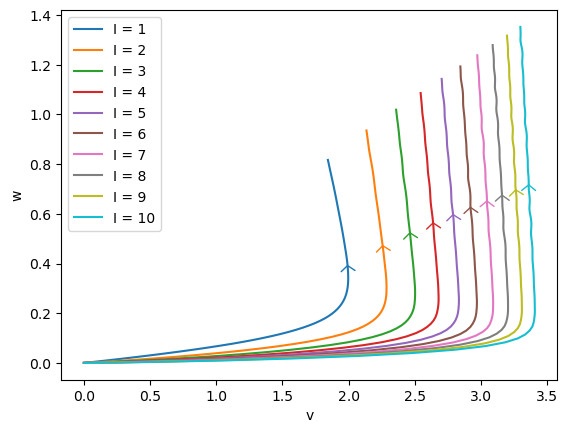

In [14]:
## Solve the system of equations for the purturbed parameters
# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the system of equations
def f(t, x, I_stim):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Define the initial condition
x0 = [0, 0]

# Create a new figure
fig, ax = plt.subplots()

# Solve the system for different values of I
for lambda_I in range(1, 11):
    # Solve the system
    sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, args=(lambda_I,), method='RK45')
    xt = sol.y

    # Plot the solution
    line, = ax.plot(xt[0], xt[1], label=f'I = {lambda_I}')

    # Add arrows to indicate direction
    middle_index = len(xt[0]) // 2
    arrowcolor = np.array(mcolors.to_rgba(line.get_color()))
    ax.annotate('', xy=(xt[0][middle_index], xt[1][middle_index]), xytext=(xt[0][middle_index-1], xt[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor=arrowcolor, edgecolor=arrowcolor))

ax.set_xlabel('v')
ax.set_ylabel('w')
ax.legend()
plt.show()

## Linearization

The linearization of a nonlinear system is given by: $$\dot{x} = f(x) \quad\mapsto\quad \dot{x} = Df(x^*)x$$ around an equilibrium point $x^*$ satisfying $f(x^*) = 0$. Thus, linearizing the system requires first finding an equilibrium.

### Equilibrium

In [15]:
## Solve for the equilibrium points
equilibria = sp.solve([dv_dt, dw_dt], (v, w))
for equilibrium in equilibria:
    print(f'An equilibrium point is at v = {equilibrium[0]}, w = {equilibrium[1]}')

An equilibrium point is at v = -1.19940803524404, w = -0.624260044055044
An equilibrium point is at v = 0.599704017622018 - 1.35238113202454*I, w = 1.62463002202752 - 1.69047641503067*I
An equilibrium point is at v = 0.599704017622018 + 1.35238113202454*I, w = 1.62463002202752 + 1.69047641503067*I


In [16]:
# Select the real equilibrium point
x_star = equilibria[0]
x_star

(-1.19940803524404, -0.624260044055044)

### Linearized system

The linearized system $\dot{x} = Ax$ is given by evaluating the Jacobian at the equilibrium $A = Df(x^*)$.

In [17]:
# Evaluate the Jacobian at the equilibrium
A = Df.subs({v: x_star[0], w: x_star[1]})
A

Matrix([
[-0.438579635007956,     -1],
[              0.08, -0.064]])

#### Hartman-Grobman Theorem

The Hartman-Grobman Theorem states that near a hyperbolic equilibrium, every nonlinear system is equivalent to a linear system.

**Theorem**

*Consider a nonlinear differential equation $\dot{x} = f(x)$, where $f: E \to \mathbb{R}^n$ is a continuously differentiable map defined on the open and connected set $E\subseteq \mathbb{R}^n$, and let $\dot{x} \in E$ be an equilibrium point. If $x^*$ is hyperbolic then there exist a neighborhood $X$ of $x^*$ (i.e., $x^* \in X \subseteq E$ with $X$ an open set) and an homeomorphism $h : X \to Y \triangleq h(X)$ mapping $x^* \in X$ to $h(x^*) = 0 ∈ Y$, satisfying the following implication (implying topological conjugacy): $$\forall x_0 \in X \space\exists a(x_0)\in \mathbb{R}_{>0} \quad\text{s.t.}\quad h(\phi_t(x_0)) = e^{At}h(x_0), \quad\forall t\in (-a(x_0),a(x_0)),$$ where $A = Df(x^*)$.*

Therefore, to apply Hartman-Grobman Theorem, we need to verify that our equilibrium is a hyperbolic one. We will do so by examining the eigenvalues of $A$ to make sure they all have nonzero real part: $\Re(\lambda) \ne 0, \space\forall \lambda\in\sigma(A)$.

In [18]:
# Check if the equilibrium is hyperbolic
from sympy import re

eig_A = list(A.eigenvals().keys())
print(f"The eigenvalues of A are {eig_A}")
hyperbolic = all(re(eig) != 0 for eig in eig_A)
print(f"All eigenvalues of A have nonzero real part: {hyperbolic}")

The eigenvalues of A are [-0.251289817503978 - 0.211949343616173*I, -0.251289817503978 + 0.211949343616173*I]
All eigenvalues of A have nonzero real part: True


Since all eigenvalues of $A$ have nonzero real part, we can apply Hartman-Grobman Theorem and conclude that locally the linearization around our equilibrium is topologically conjugate to the nonlinear flow of the system.

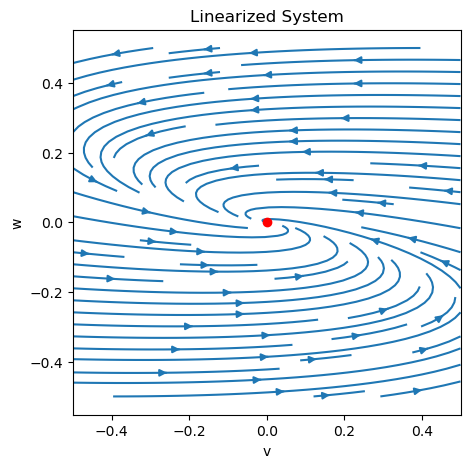

In [19]:
## Phase portrait for the linearized system
# Define the linear system
A_np = np.array(A).astype(float)
def lin_system(v, w):
    return np.einsum('ij,jkl->ikl', A_np, np.array([v, w]))

# Define the grid
vs = np.linspace(-0.5, 0.5, 20)
ws = np.linspace(-0.5, 0.5, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = lin_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(0, 'ro')
ax.set_title('Linearized System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

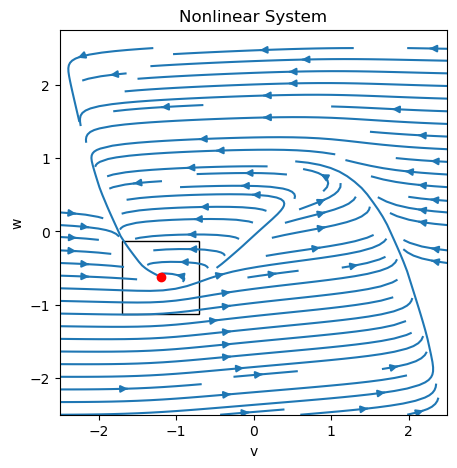

In [20]:
## Phase portrait for the nonlinear system
# Define the nonlinear system
def nl_system(v, w):
    return v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)

# Define the grid
vs = np.linspace(-2.5, 2.5, 20)
ws = np.linspace(-2.5, 2.5, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = nl_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(x_star[0], x_star[1], 'ro')
square = patches.Rectangle((x_star[0]-0.5, x_star[1]-0.5), 1, 1, fill=False)
ax.add_patch(square)
ax.set_title('Nonlinear System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

In a neighborhood of the equilibrium, our linearized system mimics the dynamics of the nonlinear system.

### Linearizing at a non-equilibrium

Does the implication of Hartman-Grobman still hold if the system is linearized at a non-equilibrium? We will arbitrarily choose to compare the linearization at the origin (which is a non-equilibrium) to the nonlinear system itself.

In [21]:
# Evaluate the Jacobian at the non-equilibrium
A_neq = Df.subs({v: 0, w: 0})
A_neq

Matrix([
[   1,     -1],
[0.08, -0.064]])

In [22]:
# Compute the eigenvalues of the Jacobian
eig_A_neq = list(A_neq.eigenvals().keys())
print(f"The eigenvalues of A_neq are {eig_A_neq}")

The eigenvalues of A_neq are [0.918581846061290, 0.0174181539387100]


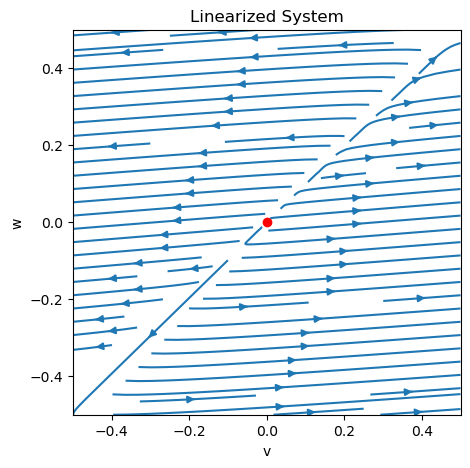

In [23]:
## Phase portrait for the linearized system
# Define the linear system
A_np = np.array(A_neq).astype(float)
def lin_system(v, w):
    return np.einsum('ij,jkl->ikl', A_np, np.array([v, w]))

# Define the grid
vs = np.linspace(-0.5, 0.5, 20)
ws = np.linspace(-0.5, 0.5, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = lin_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(0, 'ro')
ax.set_title('Linearized System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

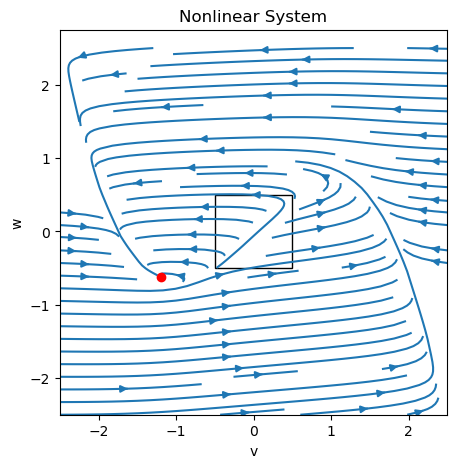

In [24]:
## Phase portrait for the nonlinear system
# Define the nonlinear system
def nl_system(v, w):
    return v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)

# Define the grid
vs = np.linspace(-2.5, 2.5, 20)
ws = np.linspace(-2.5, 2.5, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = nl_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(x_star[0], x_star[1], 'ro')
square = patches.Rectangle((-0.5, -0.5), 1, 1, fill=False)
ax.add_patch(square)
ax.set_title('Nonlinear System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

However, comparing the phase portraits of the linearized and nonlinear systems, we see that the linearized system does not capture the behavior of the nonlinear system, exemplifying that the Hartman-Grobman Theorem does not hold for this non-equilibrium.

## Lyapunov's (indirect) method for stability

Lyapunov's method essentially represent the dynamical system through a Lyapunov function $V: E\rightarrow\mathbb{R}$, which can be used to establish stability of equilibria of a nonlinear system.

**Lyapunov's Theorem**

*Let $\dot{x} = f(x)$ where $f: E \rightarrow \mathbb{R}^n$ is a locally Lipschitz continuous function defined on the open and connected set $E \subseteq \mathbb{R}^n$. Consider the equilibrium point $x^* = 0 \in E$ and the continuously differentiable function $V: E \rightarrow \mathbb{R}$ satisfying $(0) = 0$. If the following conditions are satisfied:*
- *$V(x)>0$ for all $x\in E\backslash\{0\}$;*
- *$\dot{V}(x)\le0$ for all $x\in E$,*

*then the equilibrium $x^* = 0$ is stable. If, in addition, the following condition is satisfied:*
- *$\dot{V}(x)<0$ for all $x\in E\backslash\{0\}$,*

*then the equilibrium $x^* = 0$ is asymptotically stable.*

### Lyapunov's method on linearized system

Through the *mean value theorem*, we conclude that we can use the linearized system to construct a Lyapunov function that is also valid locally for the nonlinear system. Therefore, we will consider constructing a Lyapunov function for the linearized system to attempt to establish  (exponential) stability for the nonlinear system.

Let's consider a quadratic form Lyapunov function candidate as it automatically satisfies the condition $V(x)>0$: $$V(x) = x^TPx, \quad P = P^T > 0, \quad P\in \mathbb{R}^{n\times n},$$
of which the derivative is given by: $$\dot{V}(x) = x^T(A^TP + PA)x.$$

To establish stability of the linear system through the Lyapunov function, we would like $A^TP + PA$ to be negative definite. Therefore, a symmetric positive definite matrix $P$ that also satisfies the Continuous-Time Lyapunov Equation (CTLE): $$A^TP + PA = -Q,$$ where $Q = Q^T > 0$, is defined as a Lyapunov matrix.

**Theorem**

*For a linear system $\dot{x} = Ax$, $A \in \mathbb{R}^{n\times n}$ with an isolated equilibrium $x^* = 0$, i.e., $\ker{A} = \{0\}$, the following holds: $$x^* = 0 \textit{ is globally exponentially stable}\\ \Updownarrow\\ \textit{for every } Q=Q >0 \textit{, there exists a unique } P =P >0 \textit{ such that } A^TP + PA = −Q.$$*

Thus, as long as we can find such $P$, we can establish stability for the linearized system, and consequently estimate a domain of attraction and establish stability for the nonlinear system.

Recall our linearized dynamics matrix $A = Df(x^*)$, let's pick $Q = \gamma I$ for $\gamma>0$ and solve for $P$.

In [25]:
# Define Q
gamma = sp.symbols('gamma')
Q = sp.eye(2) * gamma

# Define P symbolically
P_vars = sp.symbols('p:{0}'.format(2**2))
P = sp.Matrix(2, 2, P_vars)

# Create the equation A.T*P + P*A = -Q
equation = sp.Eq(A.T * P + P * A, -Q)

# Solve for P
solution = sp.solve(equation, P_vars)
P = sp.Matrix(2, 2, list(solution.values()))
P

Matrix([
[  1.09149174679984*gamma, -0.266174350929121*gamma],
[-0.266174350929121*gamma,   11.9714742332675*gamma]])

In [26]:
# Check if P is positive definite
eig_P = P.eigenvals()
print(f"The eigenvalues of P are {list(eig_P.keys())}")
pos_def = all(eig.as_coeff_Mul()[0].is_positive for eig in eig_P.keys())
print(f"If gamma is > 0, P is positive definite: {pos_def}")

The eigenvalues of P are [1.08498379224127*gamma, 11.9779821878261*gamma]
If gamma is > 0, P is positive definite: True


Therefore, we can now conclude that the linearized system is exponentially stable through Lyapunov's method. Next, we will describe the region around the equilibrium wherein the stability conclusion for the linearized system can also be extended to the nonlinear system, i.e., the domain of attraction.

#### Domain of attraction

**Lemma**

*Consider a continuously differentiable function $f : E\to\mathbb{R}^n$ defined on the open and connected set $E\subseteq\mathbb{R}^n$ with $f(0)=0\in E$. For any $\rho\in\mathbb{R}_{>0}$ such that $B_ρ(0)\subset E$ and for any $x\in B_ρ(0)$ there exists a decomposition: $$\dot{x} = f(x) = Df(0)x + g(x), \quad \text{with} \quad \lim_{x\to0}\frac{\|g(x)\|}{\|x\|} = 0.$$*

Through this lemma, we can see that in order for conclusions made for the linearized system to apply to the nonlinear system, we would want to bound the nonlinear component of the dynamics to establish a domain of attraction. Thus, we will decompose the nonlinear system using the mean value theorem (with a coordinate change $x \mapsto x-x^*$): $$\begin{align*} \dot{x} = f(x) &= Df(0)x + g(x)\\ &= Df(0)x + G(x)x\\ &= Df(0)x + (\int_0^1 Df(\tau x)d\tau - Df(0))x. \end{align*}$$

In [27]:
# Set up the Jacobian for integration 
tau = sp.symbols('tau')
Df_tau_x = Df.subs({v: tau*v, w: tau*w})

# Integrate the matrix function with respect to tau from 0 to 1
G = sp.integrate(Df_tau_x, (tau, 0, 1)) - Df.subs({v: 0, w: 0})
G

Matrix([
[-v**2/3, 0],
[      0, 0]])

Recall that $Df(0) = A$, and we now have $G(x) = \begin{bmatrix} -\frac{v^2}{3} & 0 \\ 0 & 0 \end{bmatrix}$.

Let's attempt to upper bound $\|x\|$ so as to define a Lyapunov sublevel set that is forward invariant, which is equivalent to our domain of attraction. Given that our linearization is exponentially stable as proven previously and the limiting behavior of the nonlinear component of the dynamics: $\lim_{x\to0}\frac{\|g(x)\|}{\|x\|} = \lim_{x\to0}\|G(x)\| = 0$, we will do so by finding $r>0$ for $N>0$ such that: $$\|x\|<r \quad\Rightarrow\quad \max_{\|x\|\le r}\|G(x)\|\le N.$$

Recall our Lyapunov function $V(x) = x^TPx$, which gives: $$\begin{align*} \dot{V}(x) &= x^T P f(x) + f(x)^T P x \\ &= x^T P (Ax + g(x)) + (x^T A^T + g(x)^T) P x \\ &= x^T (PA + A^T P)x + 2x^T P g(x) \\ &= -x^T Qx + 2x^T P g(x). \end{align*}$$
Applying the *Cauchy-Schwartz* inequality gives: $$\begin{align*} \dot{V}(x) &\le -x^TQx + 2N\lambda_{\max}(P)\|x\|^2 \\ &\le \lambda_{\min}(Q)\|x\|^2 + 2N\lambda_{\max}(P)\|x\|^2 \\ &= -(\lambda_{\min}(Q) + 2N\lambda_{\max}(P))\|x\|^2. \end{align*}$$

In [28]:
# Define the inequality
N_upper = list(Q.eigenvals().keys())[0].as_coeff_Mul()[0]/(2*list(P.eigenvals().keys())[1].as_coeff_Mul()[0])
inequality = G.norm() < N_upper
print(f'The upper bound on the norm of G is {N_upper}')

# Solve the inequality for |v|
solutions = sp.solve(inequality, v, domain=sp.S.Reals)
r_upper = float(solutions.args[1].args[1])
print(f'The upper bound on |v| is {r_upper}')

The upper bound on the norm of G is 0.0417432579343939
The upper bound on |v| is 0.3538781906294617


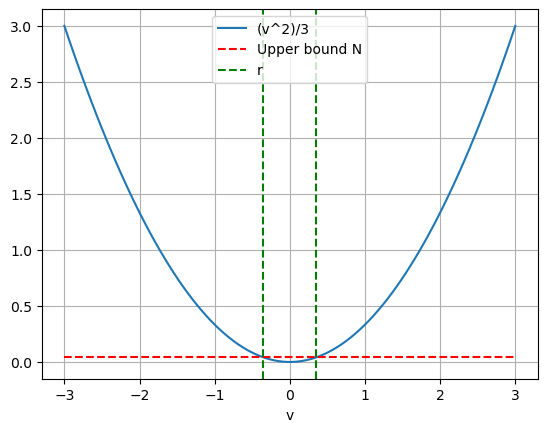

In [29]:
# Create an array of v values
vs = np.linspace(-3, 3, 100)

# Compute the y values
ys = vs**2/3

# Create the plot
plt.plot(vs, ys, label='(v^2)/3')
plt.plot(vs, N_upper*np.ones_like(vs), 'r--', label='Upper bound N')
plt.axvline(x=-r_upper, color='g', linestyle='--', label='r')
plt.axvline(x=r_upper, color='g', linestyle='--')
plt.legend()
plt.xlabel('v')
plt.grid(True)
plt.show()

Therefore, we will then choose $N$ to establish a forward invariant Lyapunov sublevel set and subsequently obtain $r$: $$N < \frac{\lambda_{\min}(Q)}{2\lambda_{\max}(P)} = \frac{\gamma}{23.96\gamma} = \frac{1}{23.96} \quad\Rightarrow\quad |v| < 0.35 \triangleq r,$$
which can be used to establish an inner approximation of the domain of attraction $D_{oa}$ with a Lyapunov sublevel set: $$V(x) \le \beta, \quad \beta < \lambda_{min}(P)r^2.$$

In [30]:
# Find region of attraction
beta = sp.symbols('beta')

# Define the inequality
inequality = beta < list(P.eigenvals().keys())[0].as_coeff_Mul()[0]*r_upper**2

# Solve the inequality for beta
solutions = sp.solve(inequality, beta, domain=sp.S.Reals)
beta_upper = float(solutions.args[0].rhs.evalf())
print(f'The upper bound on the region of attraction is {beta_upper}')

The upper bound on the region of attraction is 0.13587227488249193


We can finally conclude the estimated domain of attraction: $\Omega_\beta \subset B_{r=0.35}(0) \subset D_{oa}$ where $\beta = 0.14$, where the Lyapunov sublevel set: $$\Omega_\beta = \{x\in E\subseteq\mathbb{R}^2: V(x) \le 0.14\}$$

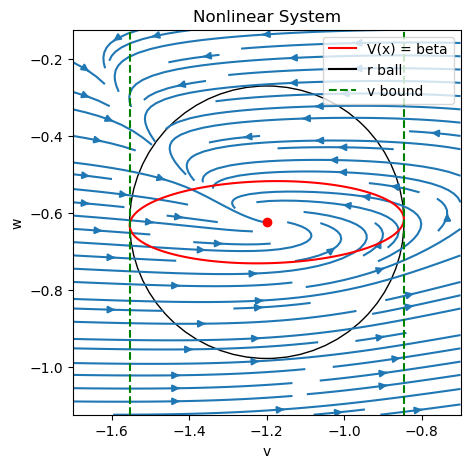

In [31]:
## Phase portrait for the nonlinear system
from matplotlib.lines import Line2D

# Define the nonlinear system
def nl_system(v, w):
    return v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)

# Define the grid
vs = np.linspace(float(x_star[0]-0.5), float(x_star[0]+0.5), 20)
ws = np.linspace(float(x_star[1]-0.5), float(x_star[1]+0.5), 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = nl_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(x_star[0], x_star[1], 'ro')

# Define the variables
sp.symbols('V x')

# Define the Lyaupnov function
x = sp.Matrix([v, w])
V = (x.T * P * x).subs({gamma: 1})

# Plot the Lyapunov level set
v_values = np.linspace(float(x_star[0]-0.5), float(x_star[0]+0.5), 400)
w_values = np.linspace(float(x_star[1]-0.5), float(x_star[1]+0.5), 400)
v_grid, w_grid = np.meshgrid(v_values, w_values)
V_func = sp.lambdify((v, w), V, "numpy")
V_grid = V_func(v_grid - float(x_star[0]), w_grid - float(x_star[1]))[0, 0, :, :]
ax.contour(v_grid, w_grid, V_grid, levels=[beta_upper], colors='r')

# Plot the r ball
circle = patches.Circle(x_star, r_upper, fill=False)
ax.add_patch(circle)

# Plot the v bound
ax.axvline(float(x_star[0])-r_upper, color='g', linestyle='--')
ax.axvline(float(x_star[0])+r_upper, color='g', linestyle='--')

proxy = Line2D([0], [0], linestyle='-', color='r')  # create a red line as a proxy artist
proxy2 = Line2D([0], [0], linestyle='-', color='k')
proxy3 = Line2D([0], [0], linestyle='--', color='g')
ax.legend([proxy, proxy2, proxy3], ['V(x) = beta', 'r ball', 'v bound'])

ax.set_title('Nonlinear System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

## Simulation of spiking activity

In this section, we will use the FizHugh-Nagumo system to simulate the spiking activity of a neuron subject to a constant current injection. 

In [111]:
## Define the system subject to a constant current input, I_stim = 0.5
# Define the variables
v, w = sp.symbols('v w')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I_stim = 0.5

# Define the system of differential equations
dv_dt = v - (v**3)/3 - w + I_stim
dw_dt = epsilon * (v + a - b*w)
f = sp.Matrix([dv_dt, dw_dt])

# Print the equations
print("dv/dt =", dv_dt)
print("dw/dt =", dw_dt)

dv/dt = -v**3/3 + v - w + 0.5
dw/dt = 0.08*v - 0.064*w + 0.056


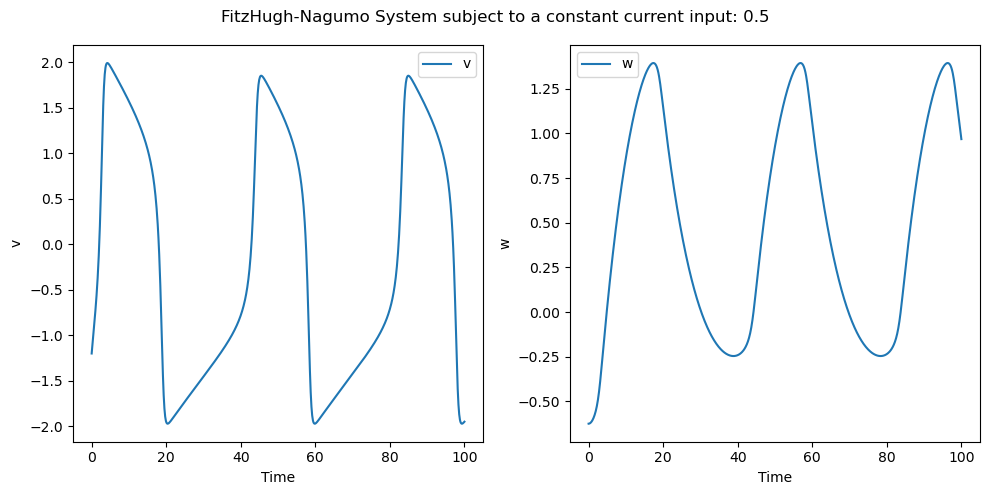

In [112]:
## Forward simulate the system's response dynamics
from scipy.integrate import odeint

# Convert SymPy expressions to numerical functions
f_num = sp.lambdify((v, w), [expr for expr in f], 'numpy')

# Define the system of differential equations for odeint
def system(x, t):
    return f_num(*x)

# Define the initial conditions
x0 = x_star

# Define the time points
t0, t_final = 0, 100
n = (t_final - t0)*10
t = np.linspace(t0, t_final, n)

# Forward simulate the system
sol = odeint(system, x0, t)

# Plot the solution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(t, sol[:, 0], label='v')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('v')
axs[0].legend()

axs[1].plot(t, sol[:, 1], label='w')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('w')
axs[1].legend()

fig.suptitle(f'FitzHugh-Nagumo System subject to a constant current input: {I_stim}')
fig.tight_layout()
plt.show()

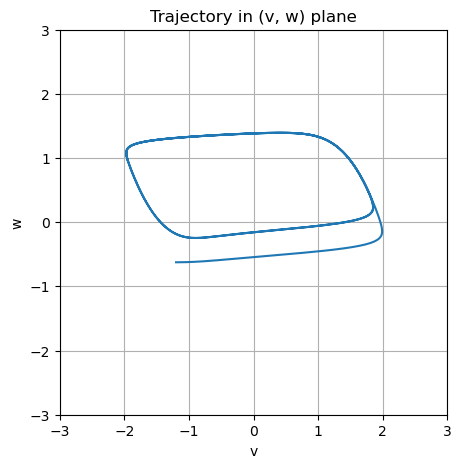

In [113]:
# Plot the trajectory in the (v, w) plane
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(sol[:, 0], sol[:, 1])
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.set_title('Trajectory in (v, w) plane')
ax.grid(True)
plt.show()

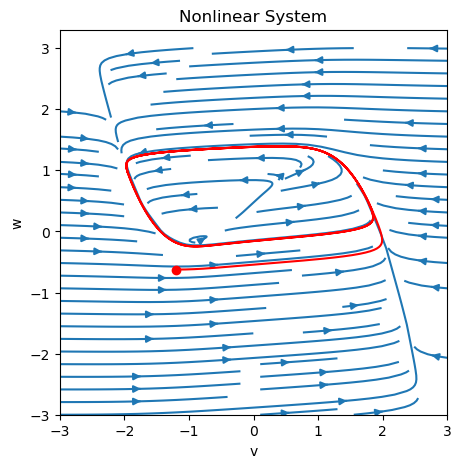

In [114]:
## Phase portrait for the nonlinear system
# Define the nonlinear system
def nl_system(v, w):
    return v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)

# Define the grid
vs = np.linspace(-3, 3, 20)
ws = np.linspace(-3, 3, 20)
Vs, Ws = np.meshgrid(vs, ws)

# Compute the directional velocity at each point on the grid
v_direction, w_direction = nl_system(Vs, Ws)

# Plot the phase portrait
fig, ax = plt.subplots(figsize=(5, 5))
ax.streamplot(Vs, Ws, v_direction, w_direction)
ax.plot(x_star[0], x_star[1], 'ro')
ax.plot(sol[:, 0], sol[:, 1], 'r')
ax.set_title('Nonlinear System')
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.show()

It can be seen that in our forward simulation, the system seems to transition into a stable periodic orbit subject to a constant input. This observation may prompt us to investigate the system's input-to-state stability and stability of periodic orbits.

## Input-to-state stability

A system of the form: $$\dot{x} = f(x, u),$$ where $u$ is a continuous function for control inputs or disturbances, is said to be *input-to-state stable* if it satisfies that, assuming $t_0=0$: $$\|x_0\| \le a \quad\Rightarrow\quad \|x(t)\| \le \beta(\|x_0\|, t) + \gamma(\|u\|_\infty),$$ where $u$ is *essentially bounded*: $$\|u(t)\|_\infty \triangleq \operatorname*{ess\,sup}_{t\ge0}\|u(t)\|.$$

### ISS Lyapunov functions

We can also use Lyapunov functions to characterize ISS.

**Theorem**

*Consider the system $\dot{x} = f(x,u)$, where $f: E \times \mathbb{R}^m \rightarrow \mathbb{R}^n$ is a locally Lipschitz continuous function and $E \subseteq \mathbb{R}^n$ is an open and connected set for which $E \times \mathbb{R}^m$ contains the equilibrium pair $(x^*, u^*) = (0, 0)$. If there exists an ISS Lyapunov function, i.e., a continuously differentiable function $V: E \rightarrow \mathbb{R}$ satisfying: $$\begin{align*} \alpha_1(\|x\|) < V(x) &< \alpha_2(\|x\|)\\ \|x\| \ge \rho(\|u\|) \quad\Rightarrow\quad \dot{V}(x,u) = \left.\frac{\partial V}{\partial x}\right|_x f(x, u) &\le -\alpha_3(\|x\|), \end{align*}$$ for all $x \in E$ and $u \in \mathbb{R}^m$, where $\alpha_1, \alpha_2, \alpha_3, \rho \in \mathcal{K}$, then the system $\dot{x} = f(x,u)$ is ISS.*

It is difficult to find a suitable Lyapunov function for the nonlinear system. However, we can gain some insights into the input-to-state stability of the equilibrium by varying the input term, $I_{stim}$, as a constant, for which the essential supremum is $\|u\|_\infty \equiv I_{stim}$.

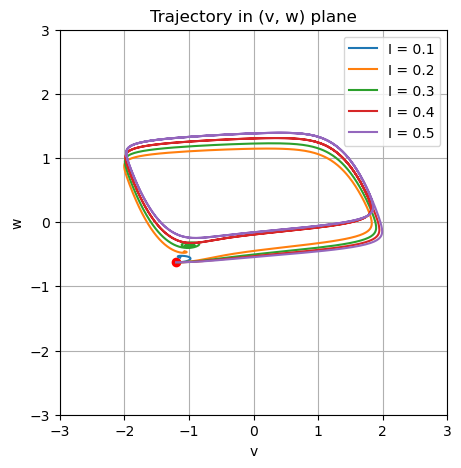

In [106]:
# Define the variables
v, w, I_stim = sp.symbols('v w I_stim')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I_stims = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the system of differential equations
dv_dt = v - (v**3)/3 - w + I_stim
dw_dt = epsilon * (v + a - b*w)
f = sp.Matrix([dv_dt, dw_dt])

# Convert SymPy expressions to numerical functions
f_num = sp.lambdify((v, w, I_stim), [expr for expr in f], 'numpy')

# Define the system of differential equations for odeint
def system(x, t, I_stim):
    return f_num(*x, I_stim)

# Define the initial conditions
x0 = x_star

# Define the time points
t0, t_final = 0, 100
n = (t_final - t0)*10
t = np.linspace(t0, t_final, n)

# Forward simulate the system
sols = [odeint(system, x0, t, args=(I_stim,)) for I_stim in I_stims]

# Plot the trajectories in the (v, w) plane
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_star[0], x_star[1], 'ro')
for sol, I_stim in zip(sols, I_stims):
    ax.plot(sol[:, 0], sol[:, 1], label=f'I = {I_stim}')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.legend()
ax.set_title('Trajectory in (v, w) plane')
ax.grid(True)
plt.show()

## Stability of periodic orbits and Poincaré maps

We can determine the stability of a period orbit by determining the stability of a Poincaré map, which defines a discrete-time dynamical system: $$z_{k+1} = P_\Sigma(z_k),$$ on the manifold $\Sigma$ that exists in $\mathbb{R}^{n-1}$ called the Poincaré section.

**Theorem (Poincaré map)**

*Let $x_0 \in \mathcal{O}$ be a point in a periodic orbit $\mathcal{O}$, of period $T \in \mathbb{R}_{>0}$, for a nonlinear system $\dot{x} = f(x)$ defined by the continuously differentiable function $f: E \rightarrow \mathbb{R}^n$ on the open and connected set $E \subseteq \mathbb{R}^n$. For a Poincaré section $\Sigma$ associated with $\mathcal{O}$ there exists an $r > 0$ and a unique continuously differentiable function, termed the time-to-impact function and denoted by $\tau: B_r(x_0) \cap \Sigma \rightarrow \mathbb{R}$, such that: $$\tau(x_0)=T, \quad\phi_{\tau(x)}(x)\in\Sigma, \quad\forall x\in B_r(x_0)\cap\Sigma.$$ The Poincaré map is, therefore, defined to be the function: $$\begin{align*} P: B_r(x_0)\cap\Sigma &\rightarrow \Sigma\\ x &\mapsto P(x)\triangleq \phi_{\tau(x)}(x). \end{align*}$$*

Also, there exists a diffeomorphism: $$\psi: B_r(x_0)\cap\Sigma \rightarrow W \subset \mathbb{R}^{n-1}$$.

The stability of the periodic orbit and the discrete-time dynamical system defined by the Poincaré map can be directly related.

**Theorem**

*Let $\mathcal{O}$ be a periodic orbit of the nonlinear system $\dot{x} = f(x)$, where $f: E \rightarrow \mathbb{R}^n$ is continuously differentiable and defined on the open and connected set $E \subseteq \mathbb{R}^n$, and let $P$ be the Poincaré map associated with a Poincaré section $\Sigma$, wherein $P_\Sigma: \Sigma \rightarrowtail \Sigma$ defines the discrete-time dynamical system $z_{k+1} = P_\Sigma(z_k)$ with a unique fixed point $z^* = P_\Sigma(z^*)$, i.e., $\mathcal{O}\cap\Sigma$ is a singleton. Then the following are equivalent: $$\begin{align*} \mathcal{O}\textit{ is stable} \quad&\iff\quad z^* \textit{ is stable}\\ \mathcal{O}\textit{ is asymptotically stable} \quad&\iff\quad z^* \textit{ is asymptotically stable}\\ \mathcal{O}\textit{ is exponentially stable} \quad&\iff\quad z^* \textit{ is exponentially stable} \end{align*}$$*

Based on observation, it is reasonable to pick a Poincaré section that is the positive $w$-axis. In this case, $z$ is equivalent to the $w$-value of the solution. Therefore, we can examine the points where the solution crosses the positive $w$-axis to infer the stability of the periodic orbit.

In [133]:
## Define the system subject to a constant current input, I_stim = 0.5
# Define the variables
v, w = sp.symbols('v w')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I_stim = 0.5

# Define the system of differential equations
dv_dt = v - (v**3)/3 - w + I_stim
dw_dt = epsilon * (v + a - b*w)
f = sp.Matrix([dv_dt, dw_dt])

# Convert SymPy expressions to numerical functions
f_num = sp.lambdify((v, w), [expr for expr in f], 'numpy')

# Define the system of differential equations for odeint
def system(x, t):
    return f_num(*x)

# Define the initial conditions
x0 = x_star

# Define the time points
t0, t_final = 0, 1000
n = (t_final - t0)*10_000
t = np.linspace(t0, t_final, n)

# Forward simulate the system
sol = odeint(system, x0, t)

# Find points where the solution crosses the positive v-axis
crossing_points = []
for i in range(1, len(sol)):
    if np.sign(sol[i-1, 0]) != np.sign(sol[i, 0]) and sol[i, 1] > 0:
        crossing_points.append(sol[i])

crossing_points = np.array(crossing_points)
crossing_points

array([[-1.31409344e-05,  1.38458612e+00],
       [-6.27256462e-06,  1.38458629e+00],
       [-8.81128010e-05,  1.38458330e+00],
       [-8.13259669e-05,  1.38458353e+00],
       [-7.49644434e-05,  1.38458375e+00],
       [-6.84756767e-05,  1.38458400e+00],
       [-6.14463996e-05,  1.38458426e+00],
       [-5.46615260e-05,  1.38458451e+00],
       [-4.81883504e-05,  1.38458474e+00],
       [-4.18405308e-05,  1.38458498e+00],
       [-3.52183700e-05,  1.38458522e+00],
       [-2.84370078e-05,  1.38458548e+00],
       [-2.17284407e-05,  1.38458572e+00],
       [-1.49695050e-05,  1.38458598e+00],
       [-8.55336467e-06,  1.38458623e+00],
       [-1.80700614e-06,  1.38458646e+00],
       [-8.35880706e-05,  1.38458344e+00],
       [-7.72138066e-05,  1.38458368e+00],
       [-7.06726035e-05,  1.38458392e+00],
       [-6.38066816e-05,  1.38458417e+00],
       [-5.71663177e-05,  1.38458442e+00],
       [-5.06625710e-05,  1.38458466e+00],
       [-4.38808952e-05,  1.38458491e+00],
       [-3.

It appears that the $w$-value remains relatively stable forward in the numerical solution, suggesting that there may exist a periodic orbit which may be stable.